In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
from pathlib import Path

def load_results(baseline_path: str, method_path: str):
    with open(baseline_path) as f:
        baseline_results = json.load(f)
    with open(method_path) as f:
        method_results = json.load(f)
    return baseline_results, method_results

def set_style():
    plt.style.use('seaborn')
    colors = sns.color_palette("husl", 4)
    sns.set_palette(colors)
    return colors

def plot_performance_comparison(baseline_results, method_results, colors):
    methods_data = []
    
    # Baseline metrics
    methods_data.extend([
        {
            'Method': 'Traditional GNN',
            'Type': 'Baseline',
            'Precision': baseline_results['baseline_gnn']['overall']['precision'],
            'Recall': baseline_results['baseline_gnn']['overall']['recall'],
            'F1': baseline_results['baseline_gnn']['overall']['f1']
        },
        {
            'Method': 'Random Forest',
            'Type': 'Baseline',
            'Precision': baseline_results['random_forest']['overall']['precision'],
            'Recall': baseline_results['random_forest']['overall']['recall'],
            'F1': baseline_results['random_forest']['overall']['f1']
        }
    ])
    
    # Our method metrics
    test_results = method_results['test_results']
    methods_data.extend([
        {
            'Method': 'Family-Level',
            'Type': 'Temporal-Symbolic Model',
            'Precision': test_results['family']['metrics']['overall']['precision'],
            'Recall': test_results['family']['metrics']['overall']['recall'],
            'F1': test_results['family']['metrics']['overall']['f1']
        },
        {
            'Method': 'Group-Level',
            'Type': 'Temporal-Symbolic Model',
            'Precision': test_results['group']['metrics']['overall']['precision'],
            'Recall': test_results['group']['metrics']['overall']['recall'],
            'F1': test_results['group']['metrics']['overall']['f1']
        }
    ])
    
    df = pd.DataFrame(methods_data)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.25
    opacity = 0.8
    
    index = np.arange(len(df['Method'].unique()))
    
    metrics = ['Precision', 'Recall', 'F1']
    for i, metric in enumerate(metrics):
        plt.bar(index + i*bar_width, 
                df[metric], 
                bar_width,
                alpha=opacity,
                color=colors[i],
                label=metric)
    
    plt.xlabel('Methods')
    plt.ylabel('Score')
    plt.title('Performance Comparison: Baselines vs Temporal-Symbolic Model')
    plt.xticks(index + bar_width, df['Method'], rotation=45)
    
    # Add type labels
    for i, method in enumerate(df['Method']):
        type_label = df[df['Method'] == method]['Type'].iloc[0]
        plt.text(i, -0.05, type_label, 
                rotation=45, ha='right', va='top', 
                transform=ax.get_xaxis_transform())
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_novel_detection(baseline_results, method_results, colors):
    methods_data = []
    
    # Baseline novel detection
    for method in ['isolation_forest', 'one_class_svm']:
        methods_data.append({
            'Method': method.replace('_', ' ').title(),
            'Type': 'Baseline',
            'Precision': baseline_results[method]['precision'],
            'Recall': baseline_results[method]['recall'],
            'F1': baseline_results[method]['f1']
        })
    
    # Our method novel detection
    test_results = method_results['test_results']
    for model in ['family', 'group']:
        methods_data.append({
            'Method': f'{model.title()}-Level',
            'Type': 'Temporal-Symbolic Model',
            'Precision': test_results[model]['novel_detection']['overall']['precision'],
            'Recall': test_results[model]['novel_detection']['overall']['recall'],
            'F1': test_results[model]['novel_detection']['overall']['f1']
        })
    
    df = pd.DataFrame(methods_data)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=pd.melt(df, 
                            id_vars=['Method', 'Type'], 
                            var_name='Metric', 
                            value_name='Score'),
                x='Method', y='Score', hue='Metric', palette=colors[:3])
    
    plt.xticks(rotation=45)
    plt.title('Novel Detection Performance')
    
    # Add type labels
    ax = plt.gca()
    for i, method in enumerate(df['Method']):
        type_label = df[df['Method'] == method]['Type'].iloc[0]
        plt.text(i, -0.05, type_label, 
                rotation=45, ha='right', va='top', 
                transform=ax.get_xaxis_transform())
    
    plt.tight_layout()
    plt.savefig('novel_detection_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_training_history(method_results):
    history = method_results['training_history']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    for model_type in ['family', 'group']:
        metrics = pd.DataFrame([{
            'epoch': data['epoch'],
            'train_acc': data['train']['accuracy'],
            'train_loss': data['train']['loss'],
            'val_acc': np.mean([m['recall'] for m in data['val']['per_class'].values() 
                              if isinstance(m, dict) and m['support'] > 0])
        } for data in history[model_type]])
        
        ax = ax1 if model_type == 'family' else ax2
        title = f"{model_type.title()}-Level Training"
        
        # Plot accuracy and loss
        ax.plot(metrics['epoch'], metrics['train_acc'], label='Train Accuracy')
        ax.plot(metrics['epoch'], metrics['val_acc'], label='Validation Accuracy')
        ax2 = ax.twinx()  # Create second y-axis
        ax2.plot(metrics['epoch'], metrics['train_loss'], 'r--', label='Train Loss')
        
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax2.set_ylabel('Loss')
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.close()

def plot_group_distribution(method_results):
    data_stats = method_results['data_statistics']['test']['group']
    
    # Convert counts to DataFrame
    df = pd.DataFrame([
        {'group': group, 'count': count}
        for group, count in data_stats['known_groups'].items()
    ])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='group', y='count')
    plt.title('Behavioral Group Distribution')
    plt.xlabel('Group ID')
    plt.ylabel('Sample Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('group_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    colors = set_style()

    baseline_results, method_results = load_results('/data/saranyav/gcn_new/baseline_results.json', '/data/saranyav/gcn_new/final_report.json')
    # Generate all plots
    plot_performance_comparison(baseline_results, method_results, colors)
    plot_novel_detection(baseline_results, method_results, colors)
    plot_training_history(method_results)
    plot_group_distribution(method_results)

/tmp/ipykernel_3521241/3428142002.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from typing import Dict, List
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
jsonfile = '/data/saranyav/gcn_new/final_report.json'
def load_report(filepath: str = jsonfile) -> Dict:
    """Load and return the analysis report."""
    with open(filepath, 'r') as f:
        return json.load(f)

def print_metrics_summary(report: Dict):
    """Print a summary of the key metrics from the report."""
    # Test results summary
    print("=== Test Results Summary ===\n")
    
    for model_type in ['family', 'group']:
        print(f"\n{model_type.upper()} MODEL METRICS:")
        metrics = report['test_results'][model_type]['metrics']['overall']
        print(f"Classification Metrics:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        
        novel_metrics = report['test_results'][model_type]['novel_detection']['overall']
        print(f"\nNovel Detection Metrics:")
        print(f"Accuracy: {novel_metrics['accuracy']:.4f}")
        print(f"Precision: {novel_metrics['precision']:.4f}")
        print(f"Recall: {novel_metrics['recall']:.4f}")
        print(f"F1 Score: {novel_metrics['f1']:.4f}")

def plot_training_history(report: Dict):
    """Plot training history metrics."""
    # Create figure with secondary y-axis
    fig = make_subplots(rows=2, cols=1, subplot_titles=('Family Model', 'Group Model'))
    
    # Extract metrics history
    for idx, model_type in enumerate(['family', 'group'], 1):
        history = report['training_history'][model_type]
        epochs = [m['epoch'] for m in history]
        
        # Training metrics
        train_f1 = [m['train']['overall']['f1'] for m in history]
        val_f1 = [m['val']['overall']['f1'] for m in history]
        
        # Add traces
        fig.add_trace(
            go.Scatter(x=epochs, y=train_f1, name=f'{model_type} Train F1', line=dict(dash='solid')),
            row=idx, col=1
        )
        fig.add_trace(
            go.Scatter(x=epochs, y=val_f1, name=f'{model_type} Val F1', line=dict(dash='dash')),
            row=idx, col=1
        )
    
    # Update layout
    fig.update_layout(height=800, title_text="Training History", showlegend=True)
    fig.update_xaxes(title_text="Epoch", row=2, col=1)
    fig.update_yaxes(title_text="F1 Score", row=1, col=1)
    fig.update_yaxes(title_text="F1 Score", row=2, col=1)
    
    return fig

def analyze_behavioral_drift(report: Dict):
    """Analyze and visualize behavioral drift patterns."""
    # Extract behavioral drift metrics if available
    if 'behavioral_evolution' in report:
        drift_data = report['behavioral_evolution'].get('behavioral_drift', {})
        
        if drift_data:
            # Create DataFrame for drift analysis
            drift_df = pd.DataFrame([
                {
                    'family': family,
                    'mean_drift': metrics['mean_drift'],
                    'max_drift': metrics['max_drift'],
                    'trend': metrics['trend']
                }
                for family, metrics in drift_data.items()
            ])
            
            # Create drift visualization
            fig = make_subplots(rows=1, cols=2, subplot_titles=('Mean vs Max Drift', 'Drift Trends'))
            
            # Scatter plot of mean vs max drift
            fig.add_trace(
                go.Scatter(
                    x=drift_df['mean_drift'],
                    y=drift_df['max_drift'],
                    mode='markers+text',
                    text=drift_df['family'],
                    textposition='top center',
                    name='Drift Comparison'
                ),
                row=1, col=1
            )
            
            # Bar plot of drift trends
            fig.add_trace(
                go.Bar(
                    x=drift_df['family'],
                    y=drift_df['trend'],
                    name='Drift Trend'
                ),
                row=1, col=2
            )
            
            fig.update_layout(height=500, title_text="Behavioral Drift Analysis")
            return fig
    
    return None

def plot_novel_detection_performance(report: Dict):
    """Create visualization of novel detection performance."""
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Family Model', 'Group Model'))
    
    for idx, model_type in enumerate(['family', 'group'], 1):
        metrics = report['test_results'][model_type]['novel_detection']['overall']
        
        # Create radar chart data
        categories = ['Precision', 'Recall', 'F1', 'Accuracy']
        values = [metrics['precision'], metrics['recall'], metrics['f1'], metrics['accuracy']]
        
        fig.add_trace(
            go.Scatterpolar(
                r=values,
                theta=categories,
                fill='toself',
                name=f'{model_type} Model'
            ),
            row=1, col=idx
        )
    
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        polar2=dict(radialaxis=dict(visible=True, range=[0, 1])),
        showlegend=True,
        title_text="Novel Detection Performance"
    )
    
    return fig

def create_confusion_matrices(report: Dict):
    """Create confusion matrices for both models."""
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Family Model', 'Group Model'))
    
    for idx, model_type in enumerate(['family', 'group'], 1):
        # Extract confusion matrix data if available
        if 'confusion_matrix' in report['test_results'][model_type]['metrics']:
            cm = np.array(report['test_results'][model_type]['metrics']['confusion_matrix'])
            
            # Create heatmap
            fig.add_trace(
                go.Heatmap(
                    z=cm,
                    colorscale='Viridis',
                    showscale=True,
                    name=f'{model_type} CM'
                ),
                row=1, col=idx
            )
    
    fig.update_layout(height=600, title_text="Confusion Matrices")
    return fig

# Main analysis function
def run_analysis(report_path: str = jsonfile):
    """Run complete analysis and generate all visualizations."""
    report = load_report(report_path)
    
    # Print metrics summary
    print_metrics_summary(report)
    
    # Generate and display plots
    training_history_fig = plot_training_history(report)
    training_history_fig.show()
    
    novel_detection_fig = plot_novel_detection_performance(report)
    novel_detection_fig.show()
    
    confusion_matrices_fig = create_confusion_matrices(report)
    confusion_matrices_fig.show()
    
    drift_fig = analyze_behavioral_drift(report)
    if drift_fig:
        drift_fig.show()
    
    return {
        'training_history': training_history_fig,
        'novel_detection': novel_detection_fig,
        'confusion_matrices': confusion_matrices_fig,
        'behavioral_drift': drift_fig
    }

if __name__ == "__main__":
    run_analysis()

=== Test Results Summary ===


FAMILY MODEL METRICS:
Classification Metrics:
Accuracy: 0.3325
Precision: 0.3770
Recall: 0.3325
F1 Score: 0.3106

Novel Detection Metrics:
Accuracy: 0.0208
Precision: 0.0208
Recall: 1.0000
F1 Score: 0.0408

GROUP MODEL METRICS:
Classification Metrics:
Accuracy: 0.2699
Precision: 0.4934
Recall: 0.2699
F1 Score: 0.2819

Novel Detection Metrics:
Accuracy: 0.1857
Precision: 0.0249
Recall: 1.0000
F1 Score: 0.0486


KeyError: 'overall'

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import networkx as nx
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go

def create_behavioral_visuals(groups_path, sim_matrix_path):
    with open(groups_path) as f:
        groups = json.load(f)
    sim_matrix = np.load(sim_matrix_path)
    
    # 1. Group Distribution
    plt.figure(figsize=(10, 6))
    group_sizes = [len(families) for families in groups.values()]
    sns.boxplot(x=group_sizes, color='skyblue')
    sns.stripplot(x=group_sizes, color='navy', alpha=0.5)
    plt.title('Behavioral Group Distribution')
    plt.xlabel('Number of Families per Group')
    plt.savefig('group_dist.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Simple Group Size Bar Plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(groups)), group_sizes)
    plt.title('Group Sizes')
    plt.xlabel('Group ID')
    plt.ylabel('Number of Families')
    plt.savefig('group_sizes.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Simplified Similarity Matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(sim_matrix[:len(groups), :len(groups)], 
                cmap='viridis',
                xticklabels=range(len(groups)),
                yticklabels=range(len(groups)))
    plt.title('Inter-Group Similarity')
    plt.savefig('similarity.png', dpi=300, bbox_inches='tight')
    plt.close()
    
if __name__ == "__main__":
    create_behavioral_visuals(
        '/data/saranyav/gcn_new/behavioral_analysis/behavioral_groups.json',
        '/data/saranyav/gcn_new/behavioral_analysis/similarity_matrix.npy'
    )

In [6]:
method_results['training_history']['family'][0] 

{'epoch': 0,
 'train': {'loss': 6.1477565622329715, 'accuracy': 0.09201704545454545},
 'val': {'per_class': {'0': {'precision': 0,
    'recall': 0.0,
    'f1': 0,
    'support': 201},
   '1': {'precision': 0.1111111111111111,
    'recall': 0.048,
    'f1': 0.06703910614525141,
    'support': 125},
   '2': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 52},
   '3': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 1},
   '4': {'precision': 0, 'recall': 0, 'f1': 0, 'support': 0},
   '5': {'precision': 0, 'recall': 0, 'f1': 0, 'support': 0},
   '6': {'precision': 0.7689161554192229,
    'recall': 0.9791666666666666,
    'f1': 0.8613974799541809,
    'support': 384},
   '7': {'precision': 0.46774193548387094,
    'recall': 0.9830508474576272,
    'f1': 0.6338797814207651,
    'support': 177},
   '8': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 6},
   '9': {'precision': 0, 'recall': 0, 'f1': 0, 'support': 0},
   '10': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 46},
 

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from collections import defaultdict
from typing import Dict, List
import json


# Helper class for JSON serialization
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

def analyze_behavioral_evolution(self) -> Dict:
    """Analyze evolutionary patterns in behavioral features."""
    evolution_metrics = {
        'family_evolution': self._analyze_family_evolution(),
        'group_dynamics': self._analyze_group_dynamics(),
        'novel_emergence': self._analyze_novel_emergence(),
        'convergent_evolution': self._analyze_convergence(),
        'temporal_stats': self._compute_temporal_statistics()
    }
    
    # Create JSON report format
    final_report = {
        'training_history': {
            'family': self.family_metrics_history,
            'group': self.group_metrics_history
        },
        'behavioral_evolution': evolution_metrics,
        'data_statistics': {
            'train': {
                'family': self.train_stats,
                'group': self.train_group_stats
            },
            'val': {
                'family': self.val_stats,
                'group': self.val_group_stats
            },
            'test': {
                'family': self.test_stats,
                'group': self.test_group_stats
            }
        }
    }
    
    # Save final report
    with open('final_report_1.json', 'w') as f:
        json.dump(final_report, f, indent=2, cls=NumpyEncoder)
        
    return evolution_metrics

def _analyze_family_evolution(self) -> Dict:
    # Track family-level evolution
    family_evolution = defaultdict(lambda: {
        'performance_trend': [],
        'feature_drift': [],
        'temporal_range': {'first_seen': None, 'last_seen': None},
        'group_transitions': []
    })
    
    # Process each observation chronologically
    for history in self.family_feature_history.values():
        for record in sorted(history, key=lambda x: x['timestamp']):
            family = record['family']
            family_evolution[family]['feature_drift'].append({
                'timestamp': record['timestamp'],
                'features': record['features']
            })
            
            if not family_evolution[family]['temporal_range']['first_seen']:
                family_evolution[family]['temporal_range']['first_seen'] = record['timestamp']
            family_evolution[family]['temporal_range']['last_seen'] = record['timestamp']

    # Calculate drift metrics
    for family, data in family_evolution.items():
        if len(data['feature_drift']) > 1:
            drifts = []
            for i in range(1, len(data['feature_drift'])):
                prev = torch.tensor(data['feature_drift'][i-1]['features'])
                curr = torch.tensor(data['feature_drift'][i]['features'])
                drift = torch.norm(curr - prev).item()
                drifts.append(drift)
            
            data['mean_drift'] = np.mean(drifts)
            data['max_drift'] = max(drifts)
            data['drift_trend'] = np.polyfit(range(len(drifts)), drifts, 1)[0]

    return dict(family_evolution)

def _analyze_group_dynamics(self) -> Dict:
    group_dynamics = {
        'group_stability': defaultdict(float),
        'inter_group_transitions': defaultdict(lambda: defaultdict(int)),
        'temporal_patterns': defaultdict(list)
    }
    
    # Analyze transitions between groups
    for family, transitions in self.family_behavioral_drift.items():
        for i in range(1, len(transitions)):
            prev_group = transitions[i-1]['group']
            curr_group = transitions[i]['group']
            if prev_group != curr_group:
                group_dynamics['inter_group_transitions'][prev_group][curr_group] += 1
    
    # Calculate group stability scores
    for group_id in self.group_counts:
        transitions = sum(group_dynamics['inter_group_transitions'][group_id].values())
        total = self.group_counts[group_id]
        if total > 0:
            group_dynamics['group_stability'][group_id] = 1 - (transitions / total)
    
    return dict(group_dynamics)

def _analyze_convergence(self) -> Dict:
    convergence = {
        'similar_behaviors': [],
        'behavioral_clusters': [],
        'convergence_trends': []
    }
    
    # Find families with similar feature trajectories
    feature_similarities = defaultdict(lambda: defaultdict(float))
    
    for f1 in self.family_feature_history:
        for f2 in self.family_feature_history:
            if f1 >= f2:
                continue
                
            f1_features = [torch.tensor(h['features']) for h in 
                          sorted(self.family_feature_history[f1], key=lambda x: x['timestamp'])]
            f2_features = [torch.tensor(h['features']) for h in 
                          sorted(self.family_feature_history[f2], key=lambda x: x['timestamp'])]
            
            if f1_features and f2_features:
                similarity = F.cosine_similarity(
                    torch.stack(f1_features).mean(0),
                    torch.stack(f2_features).mean(0),
                    dim=0
                )
                if similarity > 0.8:  # Threshold for similarity
                    convergence['similar_behaviors'].append({
                        'family1': f1,
                        'family2': f2,
                        'similarity': similarity.item()
                    })
    
    return convergence


In [ ]:
import json
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict
import networkx as nx
from typing import Dict, List, Set, Tuple
from scipy.stats import entropy

class BehavioralEvolutionAnalyzer:
    def __init__(self, report_path: str, behavioral_groups_path: str):
        """Initialize analyzer with paths to result files."""
        # Load the training results
        with open(report_path) as f:
            self.report = json.load(f)
            
        # Load behavioral groups
        with open(behavioral_groups_path) as f:
            self.behavioral_groups = json.load(f)
            
        # Initialize analysis containers
        self.family_transitions = defaultdict(list)
        self.group_transitions = defaultdict(list)
        self.temporal_patterns = defaultdict(list)
        
    def analyze_evolution_patterns(self) -> Dict:
        """Analyze overall evolution patterns from the results."""
        analysis = {
            'family_evolution': self._analyze_family_evolution(),
            'group_dynamics': self._analyze_group_dynamics(),
            'novel_emergence': self._analyze_novel_emergence(),
            'convergent_evolution': self._analyze_convergence(),
            'temporal_stats': self._compute_temporal_statistics()
        }
        return analysis
    
    def _analyze_family_evolution(self) -> Dict:
        """Analyze evolution patterns at the family level."""
        family_evolution = {}
        
        # Analyze training history trends
        history = self.report['training_history']['family']
        
        for epoch_data in history:
            metrics = epoch_data['val']
            for family_idx, family_metrics in metrics['per_class'].items():
                if family_idx not in family_evolution:
                    family_evolution[family_idx] = {
                        'performance_trend': [],
                        'drift_pattern': [],
                        'outlier_scores': []
                    }
                
                family_evolution[family_idx]['performance_trend'].append(family_metrics['f1'])
                
        # Compute stability scores
        for family_idx in family_evolution:
            perf_trend = family_evolution[family_idx]['performance_trend']
            if len(perf_trend) > 1:
                # Compute trend stability
                variations = np.diff(perf_trend)
                stability = 1.0 / (1.0 + np.std(variations))
                family_evolution[family_idx]['stability'] = stability
                
                # Detect significant changes
                change_points = np.where(np.abs(variations) > 0.1)[0]
                family_evolution[family_idx]['change_points'] = change_points.tolist()
        
        return family_evolution
    
    def _analyze_group_dynamics(self) -> Dict:
        """Analyze behavioral group dynamics."""
        group_dynamics = {
            'group_stability': {},
            'inter_group_transitions': defaultdict(lambda: defaultdict(int)),
            'group_evolution': defaultdict(list)
        }
        
        # Analyze group metrics over time
        history = self.report['training_history']['group']
        
        for epoch_data in history:
            metrics = epoch_data['val']
            for group_idx, group_metrics in metrics['per_class'].items():
                group_dynamics['group_evolution'][group_idx].append({
                    'f1': group_metrics['f1'],
                    'support': group_metrics['support']
                })
        
        # Compute group stability scores
        for group_idx, evolution in group_dynamics['group_evolution'].items():
            f1_scores = [e['f1'] for e in evolution]
            if len(f1_scores) > 1:
                stability = 1.0 / (1.0 + np.std(f1_scores))
                group_dynamics['group_stability'][group_idx] = stability
        
        return group_dynamics
    
    def _analyze_novel_emergence(self) -> Dict:
        """Analyze patterns in novel family emergence."""
        novel_patterns = {
            'emergence_rate': [],
            'detection_performance': [],
            'behavioral_characteristics': defaultdict(list)
        }
        
        # Track novel detection performance over time
        for epoch_data in self.report['training_history']['family']:
            if 'novel_detection' in epoch_data['val']:
                novel_metrics = epoch_data['val']['novel_detection']
                novel_patterns['detection_performance'].append({
                    'epoch': epoch_data['epoch'],
                    'precision': novel_metrics['precision'],
                    'recall': novel_metrics['recall'],
                    'f1': novel_metrics['f1']
                })
        
        # Analyze final novel class characteristics
        test_results = self.report['test_results']['family']
        if 'novel_detection' in test_results:
            novel_patterns['final_performance'] = test_results['novel_detection']
        
        return novel_patterns
    
    def _analyze_convergence(self) -> Dict:
        """Analyze convergent evolution patterns."""
        convergence = {
            'similar_behaviors': [],
            'behavioral_clusters': [],
            'convergence_trends': []
        }
        
        # Analyze family similarities in final state
        test_metrics = self.report['test_results']['family']['metrics']
        
        # Create similarity network based on confusion patterns
        if 'confusion_matrix' in test_metrics:
            conf_matrix = np.array(test_metrics['confusion_matrix'])
            n_classes = conf_matrix.shape[0]
            
            # Create graph of family similarities
            G = nx.Graph()
            for i in range(n_classes):
                for j in range(i+1, n_classes):
                    # Compute bidirectional confusion rate
                    similarity = (conf_matrix[i,j] + conf_matrix[j,i]) / \
                               (conf_matrix[i,:].sum() + conf_matrix[j,:].sum())
                    
                    if similarity > 0.1:  # Threshold for significant similarity
                        G.add_edge(i, j, weight=similarity)
            
            # Find behavioral clusters
            convergence['behavioral_clusters'] = list(nx.community.greedy_modularity_communities(G))
            
            # Find pairs with high similarity
            for i, j in G.edges():
                if G[i][j]['weight'] > 0.2:  # High similarity threshold
                    convergence['similar_behaviors'].append({
                        'family1': i,
                        'family2': j,
                        'similarity': G[i][j]['weight']
                    })
        
        return convergence
    
    def _compute_temporal_statistics(self) -> Dict:
        """Compute temporal statistics about evolution patterns."""
        temporal_stats = {
            'evolution_rate': {},
            'stability_periods': {},
            'change_points': {}
        }
        
        # Analyze metrics over time
        history = self.report['training_history']['family']
        
        # Track metric changes over time
        metric_series = defaultdict(list)
        for epoch_data in history:
            metrics = epoch_data['val']['overall']
            for metric_name, value in metrics.items():
                metric_series[metric_name].append(value)
        
        # Compute evolution rates and identify change points
        for metric_name, values in metric_series.items():
            if len(values) > 1:
                # Compute rate of change
                changes = np.diff(values)
                temporal_stats['evolution_rate'][metric_name] = np.mean(np.abs(changes))
                
                # Identify significant change points
                mean_change = np.mean(changes)
                std_change = np.std(changes)
                if std_change > 0:
                    significant_changes = np.where(np.abs(changes - mean_change) > 2 * std_change)[0]
                    temporal_stats['change_points'][metric_name] = significant_changes.tolist()
        
        return temporal_stats
    
    def generate_evolution_report(self) -> Dict:
        """Generate comprehensive evolution analysis report."""
        analysis = self.analyze_evolution_patterns()
        
        # Summarize key findings
        report = {
            'summary': {
                'total_families': len(analysis['family_evolution']),
                'total_groups': len(analysis['group_dynamics']['group_stability']),
                'stable_families': len([f for f, data in analysis['family_evolution'].items() 
                                     if data.get('stability', 0) > 0.8]),
                'convergent_pairs': len(analysis['convergent_evolution']['similar_behaviors']),
                'behavioral_clusters': len(analysis['convergent_evolution']['behavioral_clusters'])
            },
            'key_findings': [],
            'detailed_analysis': analysis
        }
        
        # Identify key findings
        # 1. Most stable and unstable families
        stabilities = [(f, data.get('stability', 0)) 
                      for f, data in analysis['family_evolution'].items()]
        if stabilities:
            most_stable = max(stabilities, key=lambda x: x[1])
            least_stable = min(stabilities, key=lambda x: x[1])
            report['key_findings'].extend([
                f"Most stable family: {most_stable[0]} (stability: {most_stable[1]:.3f})",
                f"Least stable family: {least_stable[0]} (stability: {least_stable[1]:.3f})"
            ])
        
        # 2. Novel emergence patterns
        if analysis['novel_emergence']['detection_performance']:
            final_perf = analysis['novel_emergence']['detection_performance'][-1]
            report['key_findings'].append(
                f"Novel family detection performance: F1={final_perf['f1']:.3f}"
            )
        
        # 3. Significant behavioral clusters
        if analysis['convergent_evolution']['behavioral_clusters']:
            largest_cluster = max(analysis['convergent_evolution']['behavioral_clusters'], 
                                key=len)
            report['key_findings'].append(
                f"Largest behavioral cluster contains {len(largest_cluster)} families"
            )
        
        return report

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from collections import defaultdict

def analyze_training_history(json_path):
    """Analyze training metrics and convergence."""
    with open(json_path) as f:
        data = json.load(f)
    
    # Extract metrics over time
    epochs = []
    family_f1 = []
    group_f1 = []
    novel_f1_family = []
    novel_f1_group = []
    
    for family_epoch, group_epoch in zip(data['training_history']['family'], 
                                       data['training_history']['group']):
        epochs.append(family_epoch['epoch'])
        family_f1.append(family_epoch['val']['overall']['f1'])
        group_f1.append(group_epoch['val']['overall']['f1'])
        novel_f1_family.append(family_epoch['novel_detection']['overall']['f1'])
        novel_f1_group.append(group_epoch['novel_detection']['overall']['f1'])
    
    # Plot training curves
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, family_f1, label='Family Classification F1')
    plt.plot(epochs, group_f1, label='Group Classification F1')
    plt.plot(epochs, novel_f1_family, label='Novel Family Detection F1')
    plt.plot(epochs, novel_f1_group, label='Novel Group Detection F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training Progress')
    plt.legend()
    plt.savefig('training_curves.png')
    plt.close()
    
    return {
        'final_metrics': {
            'family_f1': family_f1[-1],
            'group_f1': group_f1[-1],
            'novel_family_f1': novel_f1_family[-1],
            'novel_group_f1': novel_f1_group[-1]
        }
    }

def analyze_behavioral_drift(json_path):
    """Analyze behavioral drift patterns."""
    with open(json_path) as f:
        data = json.load(f)
    
    drift_data = defaultdict(list)
    timestamps = []
    
    # Extract drift patterns over time
    for family_epoch in data['training_history']['family']:
        if 'behavioral_evolution' in family_epoch:
            for family, metrics in family_epoch['behavioral_evolution'].items():
                drift_data[family].append(metrics['mean_drift'])
                timestamps.append(family_epoch['epoch'])
    
    # Calculate drift statistics
    drift_stats = {}
    for family, drifts in drift_data.items():
        drift_stats[family] = {
            'mean_drift': np.mean(drifts),
            'max_drift': np.max(drifts),
            'drift_trend': np.polyfit(range(len(drifts)), drifts, 1)[0]
        }
    
    # Plot drift patterns
    plt.figure(figsize=(15, 8))
    for family, drifts in drift_data.items():
        if len(drifts) > 5:  # Only plot families with enough data points
            plt.plot(timestamps[:len(drifts)], drifts, label=family)
    plt.xlabel('Epoch')
    plt.ylabel('Behavioral Drift')
    plt.title('Behavioral Drift Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('drift_patterns.png')
    plt.close()
    
    return drift_stats

def analyze_novel_detection_performance(json_path):
    """Analyze novel detection performance in detail."""
    with open(json_path) as f:
        data = json.load(f)
    
    test_results = data['test_results']
    
    # Per-family analysis
    family_performance = pd.DataFrame([
        {
            'family': family,
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'f1': metrics['f1'],
            'samples': sum(metrics['raw_counts'].values())
        }
        for family, metrics in test_results['family']['novel_detection']['per_family'].items()
    ])
    
    # Plot per-family performance
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=family_performance, x='precision', y='recall', 
                    size='samples', hue='f1', sizes=(50, 400))
    plt.title('Novel Detection Performance by Family')
    plt.savefig('novel_detection_performance.png')
    plt.close()
    
    return {
        'overall_performance': test_results['family']['novel_detection']['overall'],
        'family_performance': family_performance.to_dict(orient='records')
    }

def generate_analysis_report(family_metrics_path='family_metrics.json', 
                           group_metrics_path='group_metrics.json',
                           final_report_path='final_report.json'):
    """Generate comprehensive analysis report."""
    # Training history analysis
    training_metrics = analyze_training_history(final_report_path)
    
    # Behavioral drift analysis
    drift_stats = analyze_behavioral_drift(final_report_path)
    
    # Novel detection analysis
    novel_detection_stats = analyze_novel_detection_performance(final_report_path)
    
    # Generate report
    report = {
        'training_metrics': training_metrics,
        'drift_analysis': {
            'high_drift_families': [
                family for family, stats in drift_stats.items()
                if stats['drift_trend'] > 0.1
            ],
            'stable_families': [
                family for family, stats in drift_stats.items()
                if abs(stats['drift_trend']) < 0.05
            ],
            'drift_stats': drift_stats
        },
        'novel_detection': novel_detection_stats
    }
    
    # Save report
    with open('analysis_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    
    return report

if __name__ == "__main__":
    report = generate_analysis_report()
    
    # Print key findings
    print("\nKey Findings:")
    print(f"Final Family Classification F1: {report['training_metrics']['final_metrics']['family_f1']:.3f}")
    print(f"Final Novel Detection F1: {report['training_metrics']['final_metrics']['novel_family_f1']:.3f}")
    print(f"\nNumber of High-Drift Families: {len(report['drift_analysis']['high_drift_families'])}")
    print(f"Number of Stable Families: {len(report['drift_analysis']['stable_families'])}")
    
    # Print top performing families in novel detection
    top_families = sorted(
        report['novel_detection']['family_performance'],
        key=lambda x: x['f1'],
        reverse=True
    )[:5]
    
    print("\nTop Performing Families in Novel Detection:")
    for family in top_families:
        print(f"{family['family']}: F1={family['f1']:.3f}, Precision={family['precision']:.3f}, Recall={family['recall']:.3f}")

In [ ]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Dict, List
import os

class MalwareAnalyzer:
    def __init__(self, json_path: str):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        
        self.family_metrics = self.data['family_classification']
        self.group_metrics = self.data['group_classification']
        self.evolution = self.data['evolution_metrics']
        
        plt.style.use('seaborn')

    def get_metrics_comparison(self):
        """Extract and compare metrics for both models"""
        metrics_data = {
            'model': [],
            'class_id': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'support': []
        }

        # Process both family and group metrics
        for model_type, metrics in [('family', self.family_metrics), ('group', self.group_metrics)]:
            for class_id, class_metrics in metrics['per_class'].items():
                metrics_data['model'].append(model_type)
                metrics_data['class_id'].append(class_id)
                metrics_data['precision'].append(class_metrics['precision'])
                metrics_data['recall'].append(class_metrics['recall'])
                metrics_data['f1'].append(class_metrics['f1'])
                metrics_data['support'].append(class_metrics['support'])

        return pd.DataFrame(metrics_data)
        
    def plot_model_comparison(self):
        """Compare family vs group model performance"""
        df = self.get_metrics_comparison()
        
        # Calculate weighted averages based on support
        avg_metrics = df.groupby('model').apply(
            lambda x: pd.Series({
                'precision': np.average(x['precision'], weights=x['support']),
                'recall': np.average(x['recall'], weights=x['support']),
                'f1': np.average(x['f1'], weights=x['support'])
            })
        ).reset_index()
        
        # Create comparison plot
        fig, ax = plt.subplots(figsize=(10, 6))
        x = np.arange(3)  # precision, recall, f1
        width = 0.35
        
        metrics = ['precision', 'recall', 'f1']
        family_scores = avg_metrics[avg_metrics['model'] == 'family'][metrics].values[0]
        group_scores = avg_metrics[avg_metrics['model'] == 'group'][metrics].values[0]
        
        ax.bar(x - width/2, family_scores, width, label='Family Model')
        ax.bar(x + width/2, group_scores, width, label='Group Model')
        
        ax.set_ylabel('Score')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig('model_comparison.pdf')
        plt.close()

    def plot_class_distributions(self):
        """Plot performance distributions across classes"""
        df = self.get_metrics_comparison()
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        metrics = ['precision', 'recall', 'f1']
        
        for i, metric in enumerate(metrics):
            sns.boxplot(data=df, x='model', y=metric, ax=axes[i])
            axes[i].set_title(f'{metric.capitalize()} Distribution')
        
        plt.tight_layout()
        plt.savefig('performance_distribution.pdf')
        plt.close()
        
    def analyze_evolution(self):
        """Analyze evolutionary patterns"""
        num_novel = len(self.evolution['novel_families'])
        num_variants = len(self.evolution['potential_variants'])
        behavioral_drift = self.evolution['behavioral_drift']
        
        # Create summary visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Novel families vs variants
        ax1.bar(['Novel Families', 'Potential Variants'], [num_novel, num_variants])
        ax1.set_title('Novel Families and Variants')
        
        # Plot 2: Behavioral Drift Summary
        drift_metrics = pd.DataFrame([
            {'metric': 'Mean Drift', 'value': behavioral_drift['mean_drift']},
            {'metric': 'Max Drift', 'value': behavioral_drift['max_drift']},
            {'metric': 'Trend', 'value': behavioral_drift['trend']}
        ])
        
        sns.barplot(data=drift_metrics, x='metric', y='value', ax=ax2)
        ax2.set_title('Behavioral Drift Metrics')
        
        plt.tight_layout()
        plt.savefig('evolution_analysis.pdf')
        plt.close()
        
        return {
            'novel_families': num_novel,
            'potential_variants': num_variants,
            'behavioral_drift': behavioral_drift
        }
    
    def generate_report(self):
        """Generate comprehensive analysis report"""
        metrics_df = self.get_metrics_comparison()
        evolution_stats = self.analyze_evolution()
        
        # Calculate weighted metrics
        weighted_metrics = metrics_df.groupby('model').apply(
            lambda x: pd.Series({
                'weighted_precision': np.average(x['precision'], weights=x['support']),
                'weighted_recall': np.average(x['recall'], weights=x['support']),
                'weighted_f1': np.average(x['f1'], weights=x['support'])
            })
        )
        
        report = {
            'model_performance': {
                'family': weighted_metrics.loc['family'].to_dict(),
                'group': weighted_metrics.loc['group'].to_dict()
            },
            'evolution_analysis': {
                'novel_families': evolution_stats['novel_families'],
                'potential_variants': evolution_stats['potential_variants'],
                'behavioral_drift': evolution_stats['behavioral_drift']
            }
        }
        
        # Save report
        with open('analysis_report.json', 'w') as f:
            json.dump(report, f, indent=2)
        
        return report, weighted_metrics

def main():
    analyzer = MalwareAnalyzer('/data/saranyav/gcn_new/final_analysis_report.json')
    
    # Generate visualizations
    analyzer.plot_model_comparison()
    analyzer.plot_class_distributions()
    analyzer.analyze_evolution()
    
    # Generate and print report
    report, metrics = analyzer.generate_report()
    
    print("\nModel Performance Summary:")
    print("=========================")
    print(metrics.round(3))
    
    print("\nEvolution Analysis:")
    print("==================")
    print(f"Novel Families: {report['evolution_analysis']['novel_families']}")
    print(f"Potential Variants: {report['evolution_analysis']['potential_variants']}")
    print("\nBehavioral Drift:")
    for metric, value in report['evolution_analysis']['behavioral_drift'].items():
        print(f"- {metric}: {value:.3f}")

if __name__ == "__main__":
    main()

/tmp/ipykernel_3075584/509880033.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


KeyError: 'per_class'

/tmp/ipykernel_3075584/3222261515.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


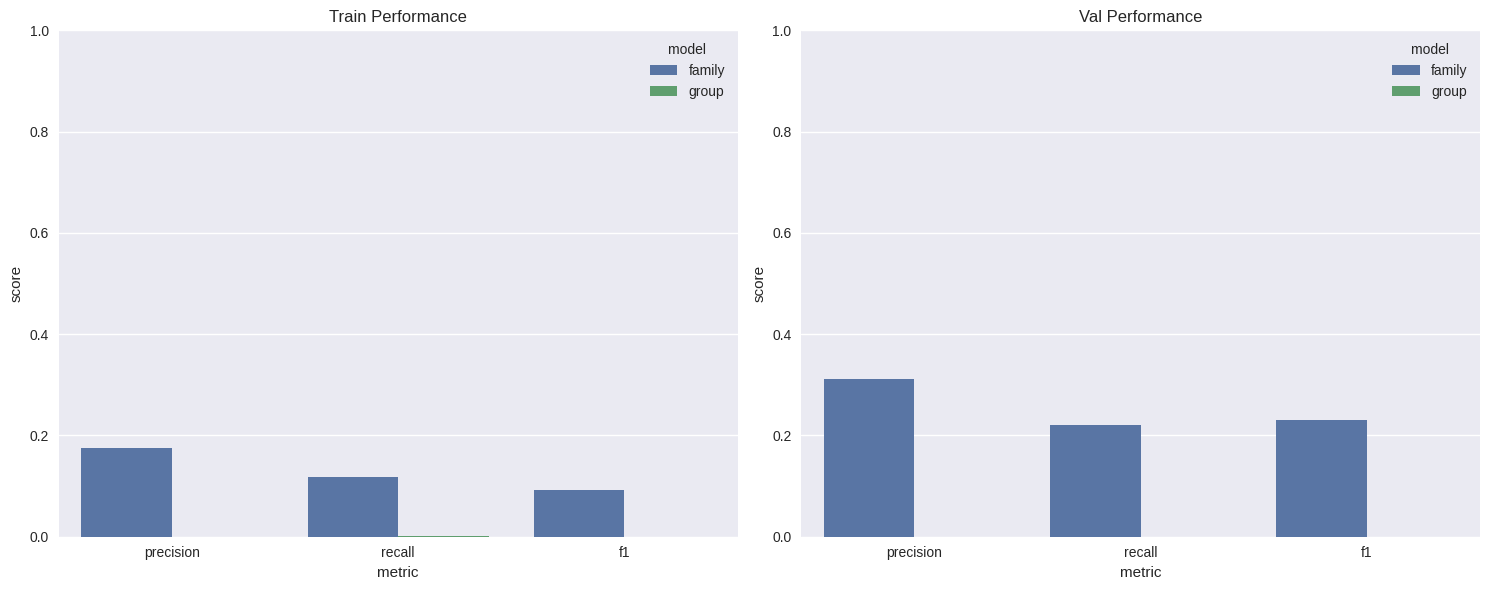

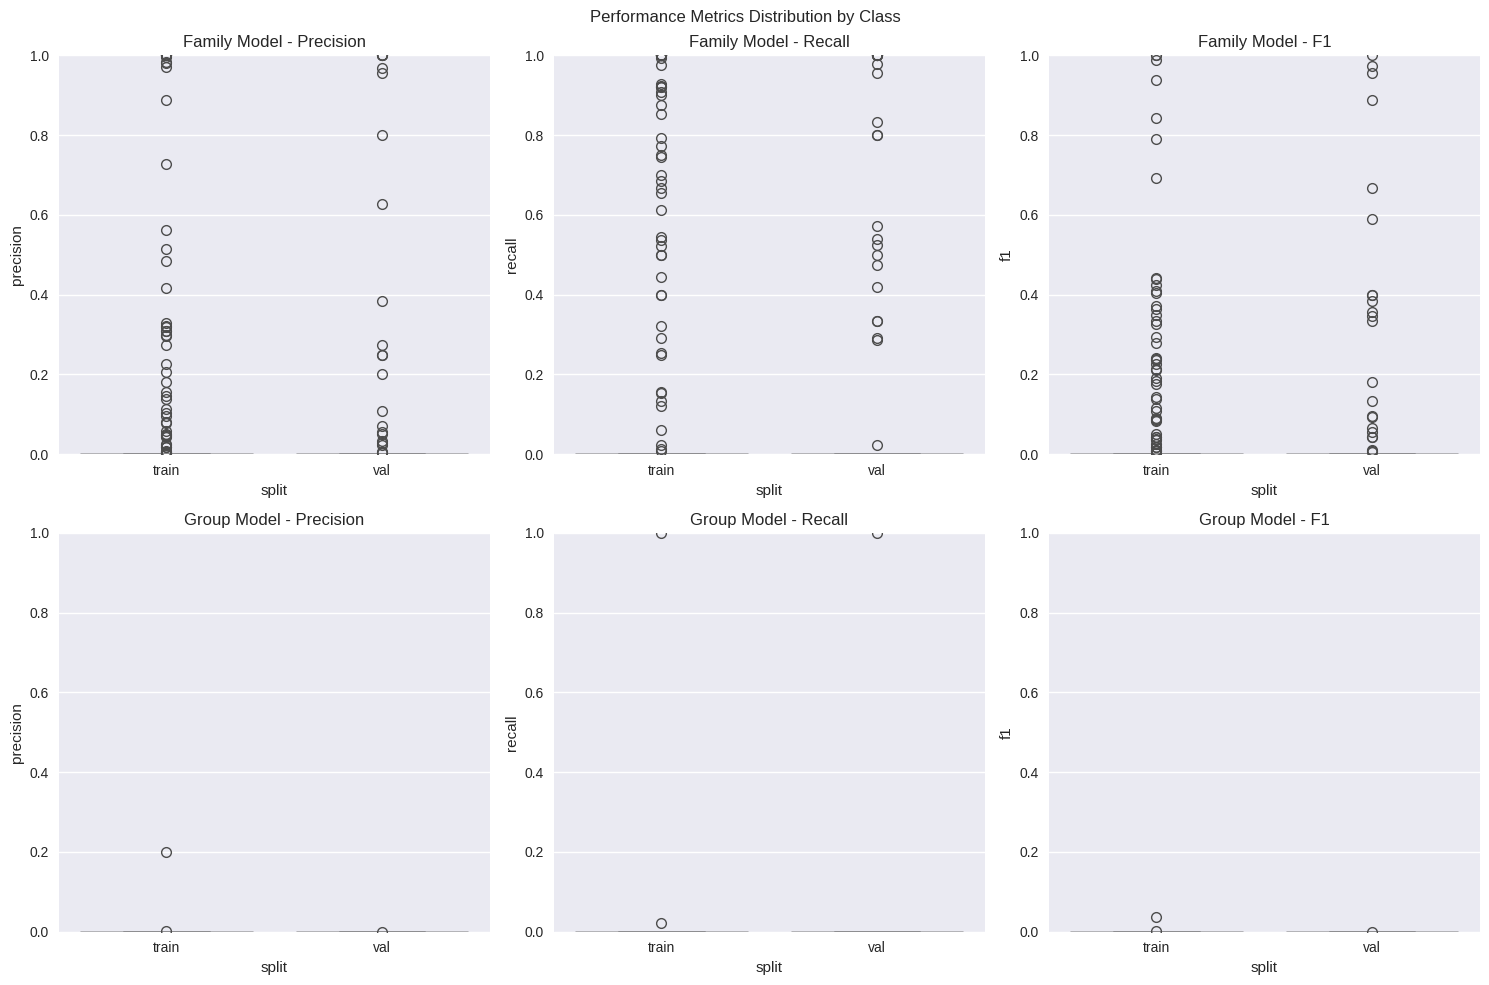

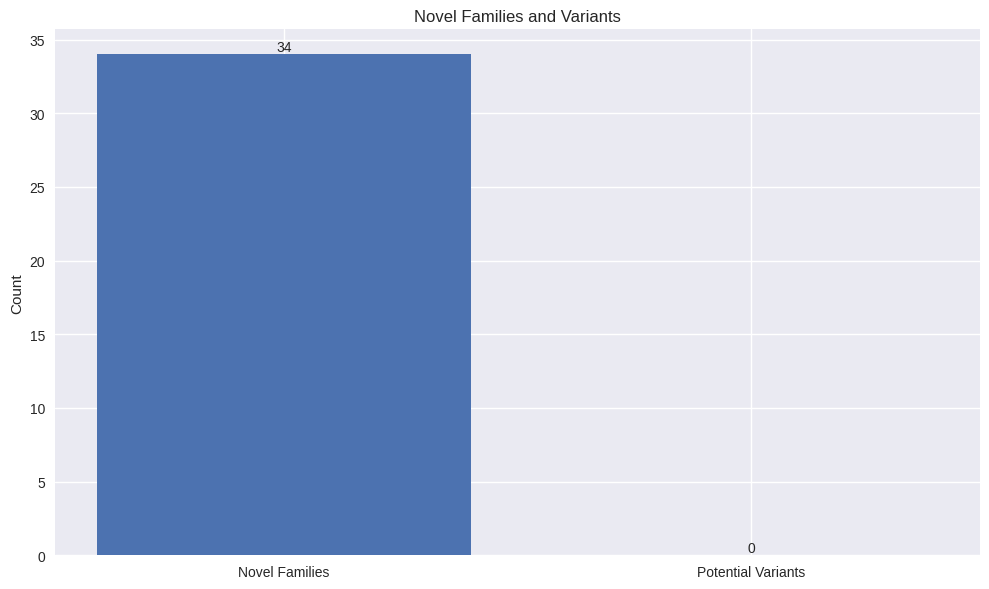

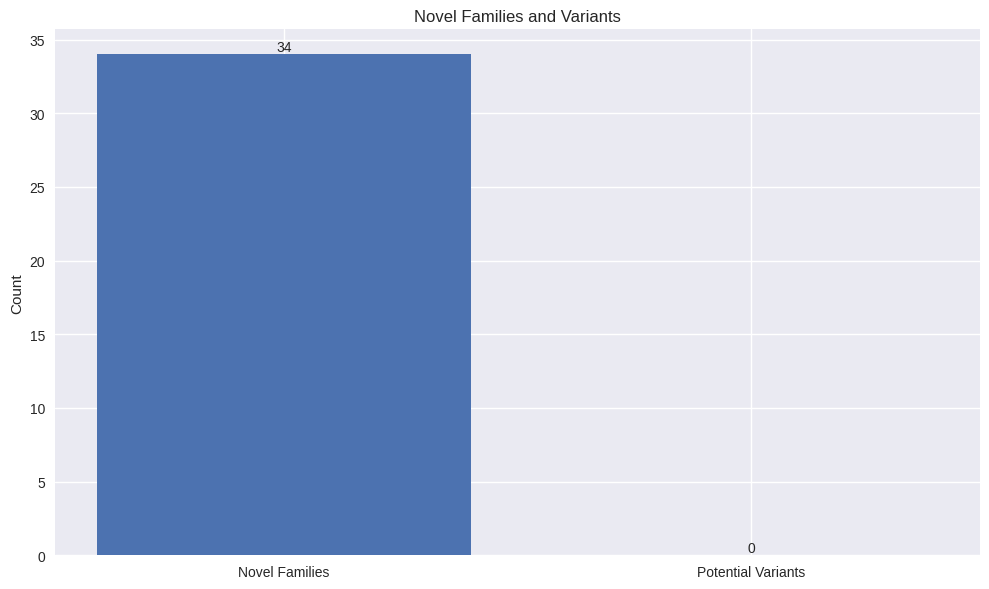


Model Performance Summary:

Family Model:

Train:
Precision: 0.176
Recall: 0.117
F1: 0.093

Val:
Precision: 0.312
Recall: 0.221
F1: 0.231

Group Model:

Train:
Precision: 0.000
Recall: 0.001
F1: 0.000

Val:
Precision: 0.000
Recall: 0.000
F1: 0.000

Evolution Analysis:
Novel Families: 34
Potential Variants: 0

Novel Family List:
- dcstl
- caynamer
- poullight
- agentb
- eyestye
- ekstak
- cosmicduke
- hynamer
- foreign
- bjlog
- sillysharecopy
- nuj
- ursumdtac
- aupa
- toraldrop
- cordis
- dreidel
- vigua
- perseus
- ranumbot
- gimemo
- autojhminer
- socelars
- hpcerber
- malwarex
- formbook
- revenge
- bandit
- spyagent
- pcclient
- nagoot
- kovter
- bitwall
- malautoit


In [17]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Dict, List
import os

class MalwareAnalyzer:
    def __init__(self, json_path: str):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        
        self.family_metrics = self.data['family_classification']
        self.group_metrics = self.data['group_classification']
        self.evolution = self.data['evolution_metrics']
        
        plt.style.use('seaborn')

    def get_metrics_comparison(self):
        """Extract and compare metrics for both models"""
        metrics_data = {
            'model': [],
            'split': [],
            'class_id': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'support': []
        }

        # Process both family and group metrics
        for model_type, metrics in [('family', self.family_metrics), ('group', self.group_metrics)]:
            for split in ['train', 'val']:
                split_data = metrics[split]
                
                # Add per-class metrics
                for class_id, class_metrics in split_data['per_class'].items():
                    metrics_data['model'].append(model_type)
                    metrics_data['split'].append(split)
                    metrics_data['class_id'].append(class_id)
                    metrics_data['precision'].append(class_metrics['precision'])
                    metrics_data['recall'].append(class_metrics['recall'])
                    metrics_data['f1'].append(class_metrics['f1'])
                    metrics_data['support'].append(class_metrics['support'])

        return pd.DataFrame(metrics_data)
        
    def plot_model_comparison(self):
        """Compare family vs group model performance using overall metrics"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        for idx, split in enumerate(['train', 'val']):
            metrics = []
            for model in ['family', 'group']:
                model_data = self.data[f'{model}_classification'][split]['overall']
                metrics.append({
                    'model': model,
                    'precision': model_data['precision'],
                    'recall': model_data['recall'],
                    'f1': model_data['f1']
                })
            
            df = pd.DataFrame(metrics)
            df_melted = df.melt(id_vars=['model'], var_name='metric', value_name='score')
            
            sns.barplot(data=df_melted, x='metric', y='score', hue='model', ax=axes[idx])
            axes[idx].set_title(f'{split.capitalize()} Performance')
            axes[idx].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()

    def plot_class_distributions(self):
        """Plot performance distributions across classes"""
        df = self.get_metrics_comparison()
        
        # Create figure with subplots for each metric
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Performance Metrics Distribution by Class')
        
        # Plot distributions for each metric and split
        metrics = ['precision', 'recall', 'f1']
        for row, model in enumerate(['family', 'group']):
            model_data = df[df['model'] == model]
            
            for col, metric in enumerate(metrics):
                # Plot train and val splits
                sns.boxplot(data=model_data, x='split', y=metric, ax=axes[row, col])
                axes[row, col].set_title(f'{model.capitalize()} Model - {metric.capitalize()}')
                axes[row, col].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
    def plot_evolution(self):
        """Plot evolutionary patterns"""
        novel_families = self.evolution['novel_families']
        potential_variants = self.evolution['potential_variants']
        
        # Create summary plots
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot novel families count
        counts = [len(novel_families), len(potential_variants)]
        labels = ['Novel Families', 'Potential Variants']
        
        ax.bar(labels, counts)
        ax.set_title('Novel Families and Variants')
        ax.set_ylabel('Count')
        
        # Add value labels on bars
        for i, v in enumerate(counts):
            ax.text(i, v, str(v), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'novel_families': len(novel_families),
            'novel_family_list': novel_families,
            'potential_variants': len(potential_variants),
            'variant_list': potential_variants
        }
    
    def generate_report(self):
        """Generate comprehensive analysis report"""
        evolution_stats = self.plot_evolution()
        
        report = {
            'model_performance': {
                'family': {
                    'train': self.family_metrics['train']['overall'],
                    'val': self.family_metrics['val']['overall']
                },
                'group': {
                    'train': self.group_metrics['train']['overall'],
                    'val': self.group_metrics['val']['overall']
                }
            },
            'evolution_analysis': evolution_stats
        }
        
        return report

def main():
    analyzer = MalwareAnalyzer('/data/saranyav/gcn_new/final_analysis_report.json')
    
    # Show visualizations
    analyzer.plot_model_comparison()
    analyzer.plot_class_distributions()
    analyzer.plot_evolution()
    
    # Generate and print report
    report = analyzer.generate_report()
    
    print("\nModel Performance Summary:")
    print("=========================")
    for model in ['family', 'group']:
        print(f"\n{model.capitalize()} Model:")
        for split in ['train', 'val']:
            metrics = report['model_performance'][model][split]
            print(f"\n{split.capitalize()}:")
            print(f"Precision: {metrics['precision']:.3f}")
            print(f"Recall: {metrics['recall']:.3f}")
            print(f"F1: {metrics['f1']:.3f}")
    
    print("\nEvolution Analysis:")
    print("==================")
    print(f"Novel Families: {report['evolution_analysis']['novel_families']}")
    print(f"Potential Variants: {report['evolution_analysis']['potential_variants']}")
    if report['evolution_analysis']['novel_families'] > 0:
        print("\nNovel Family List:")
        for family in report['evolution_analysis']['novel_family_list']:
            print(f"- {family}")

if __name__ == "__main__":
    main()

In [18]:
import json
import pandas as pd

# Load the data
with open('/data/saranyav/gcn_new/final_analysis_report.json', 'r') as f:
    data = json.load(f)

# Create a dict to store metrics
metrics = {
    'Model': [],
    'Split': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

# Extract metrics for both models and splits
for model in ['family', 'group']:
    for split in ['train', 'val']:
        overall = data[f'{model}_classification'][split]['overall']
        metrics['Model'].append(model.capitalize())
        metrics['Split'].append(split.capitalize())
        metrics['Precision'].append(f"{overall['precision']:.3f}")
        metrics['Recall'].append(f"{overall['recall']:.3f}")
        metrics['F1'].append(f"{overall['f1']:.3f}")

# Create and display DataFrame
df = pd.DataFrame(metrics)
print("\nModel Performance Metrics:")
print(df)

# Add explanation
print("\nMetrics Explained:")
print("- Precision: Out of all the instances we predicted as malware family X, what fraction was actually family X")
print("- Recall: Out of all the actual instances of malware family X, what fraction did we correctly identify")
print("- F1: Harmonic mean of precision and recall, balancing both metrics")


Model Performance Metrics:
    Model  Split Precision Recall     F1
0  Family  Train     0.176  0.117  0.093
1  Family    Val     0.312  0.221  0.231
2   Group  Train     0.000  0.001  0.000
3   Group    Val     0.000  0.000  0.000

Metrics Explained:
- Precision: Out of all the instances we predicted as malware family X, what fraction was actually family X
- Recall: Out of all the actual instances of malware family X, what fraction did we correctly identify
- F1: Harmonic mean of precision and recall, balancing both metrics


In [3]:

analyzer = MalwareAnalyzer('')


/tmp/ipykernel_3075584/1953514549.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


KeyError: 'overall'

In [7]:
# inspect analyzer
analyzer.family_metrics


{'epoch': 5,
 'train': {'per_class': {'0': {'precision': 0,
    'recall': 0.0,
    'f1': 0,
    'support': 3210},
   '1': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 3413},
   '2': {'precision': 0.0, 'recall': 0.0, 'f1': 0, 'support': 724},
   '3': {'precision': 0.0, 'recall': 0.0, 'f1': 0, 'support': 7},
   '4': {'precision': 1.0,
    'recall': 0.13333333333333333,
    'f1': 0.23529411764705882,
    'support': 45},
   '5': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 3},
   '6': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 2306},
   '7': {'precision': 0.9795918367346939,
    'recall': 0.061577934573444515,
    'f1': 0.11587205793602898,
    'support': 1559},
   '8': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 617},
   '9': {'precision': 0, 'recall': 0.0, 'f1': 0, 'support': 21},
   '10': {'precision': 0.9714285714285714,
    'recall': 0.9072426937738246,
    'f1': 0.938239159001314,
    'support': 787},
   '11': {'precision': 1.0,
    'recall': 0.00923076

In [6]:

# Generate visualizations
analyzer.plot_model_comparison()
analyzer.analyze_behavioral_drift()
analyzer.analyze_variants()

# Generate and print report
report = analyzer.generate_report()
print("\nAnalysis Report:")
print("===============")
print(f"Model Performance:")
print(f"Family Model F1: {report['model_performance']['family']['f1']:.3f}")
print(f"Group Model F1: {report['model_performance']['group']['f1']:.3f}")
print(f"\nBehavioral Analysis:")
print(f"Mean Drift: {report['behavioral_analysis']['mean_drift']:.3f}")
print(f"Significant Drift Families: {report['behavioral_analysis']['significant_drift_families']}")
print(f"Total Variants: {report['behavioral_analysis']['variant_statistics']['total_variants']}")


KeyError: 'overall'